In [241]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from flask import Flask, jsonify, request
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
import tensorflow as tf
import seaborn as sns


# The names will be the names of each column in our pandas DataFrame
names = ['age', 'sex', 'chestpaintype', 'restingbp', 'chol', 'fbs', 'restecg', 'maxhr', 'exang', 'oldpeak', 'slope', 'HeartDisease']

# Read the CSV

data = pd.read_csv('/content/heart.csv')
data.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [242]:
#no need of heart disease type in Binary table
data = data.drop('ChestPainType', axis=1)

# Display the updated DataFrame
print(data.head())

   Age Sex  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M        140          289          0     Normal    172   
1   49   F        160          180          0     Normal    156   
2   37   M        130          283          0         ST     98   
3   48   F        138          214          0     Normal    108   
4   54   M        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  


In [243]:
# Replace '?' with NaN for consistency
data.replace('?', pd.NA, inplace=True)



In [244]:
# Data Imputation
DI = data.copy()

for Fi in DI.columns:
    if DI[Fi].isna().sum() > 0.6 * len(DI):
        # Drop the column if majority values are missing
        DI = DI.drop(columns=[Fi])
    elif DI[Fi].dtype == 'object' and DI[Fi].isna().sum() < 0.4 * len(DI):
        # Fill missing categorical values with the majority label
        DI[Fi].replace('?', DI[Fi].mode().iloc[0], inplace=True)  # Replace '?' with the majority label
        DI[Fi].fillna(DI[Fi].mode().iloc[0], inplace=True)  # Fill remaining missing categorical values
    elif DI[Fi].dtype != 'object' and DI[Fi].isna().sum() < 0.4 * len(DI):
        # Fill missing numeric values with the median
        DI[Fi].replace('?', DI[Fi].median(), inplace=True)  # Replace '?' with the median
        DI[Fi].fillna(DI[Fi].median(), inplace=True)  # Fill remaining missing numeric values


# # Update the original data with imputed values
data.update(DI)
# print the last twenty or so data points with imputed value
data.loc[280:]

,Age,Sex,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
280,60,M,120,246,0,LVH,135,N,0.0,Up,0
281,49,M,150,222,0,Normal,122,N,2.0,Flat,1
282,51,F,130,220,0,Normal,160,Y,2.0,Up,0
283,55,F,110,344,0,ST,160,N,0.0,Up,0
284,42,M,140,358,0,Normal,170,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,130,236,0,LVH,174,N,0.0,Flat,1


In [245]:

# Check constant column
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [246]:
# Dataset Stratification HoldOut
val_ratio = 0.2
IH, IN = train_test_split(data.index, test_size=val_ratio, stratify=data['HeartDisease'])

IVH_idx = data.loc[IH].sample(frac=val_ratio).index
ITH_idx = IH.drop(IVH_idx)

IVN_idx = data.loc[IN].sample(frac=val_ratio).index
ITN_idx = IN.drop(IVN_idx)


train_data = data.loc[ITH_idx.append(ITN_idx)]
validation_data = data.loc[IVH_idx.append(IVN_idx)]
num_rows_train = train_data.shape[0]
num_rows_validation = validation_data.shape[0]

print("Number of rows in train_data:", num_rows_train)
print("Number of rows in validation_data:", num_rows_validation)

Number of rows in train_data: 734
Number of rows in validation_data: 184


In [247]:
#healthy vs non healthy
print(train_data['HeartDisease'].value_counts())
print(validation_data['HeartDisease'].value_counts())

1    399
0    335
Name: HeartDisease, dtype: int64
1    109
0     75
Name: HeartDisease, dtype: int64


In [248]:


# Define categorical features
categorical_features = ['Sex', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# Convert categorical features to categorical type
train_data[categorical_features] = train_data[categorical_features].astype('category')

# Separate features and labels
X = train_data.drop('HeartDisease', axis=1)
y = train_data['HeartDisease']

# Convert categorical labels to numerical form
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.select_dtypes(include=np.number))

# One-hot encode categorical features
X_categorical = pd.get_dummies(X[categorical_features])

# Concatenate scaled numerical features with one-hot encoded categorical features
X_final = np.concatenate([X_scaled, X_categorical], axis=1)





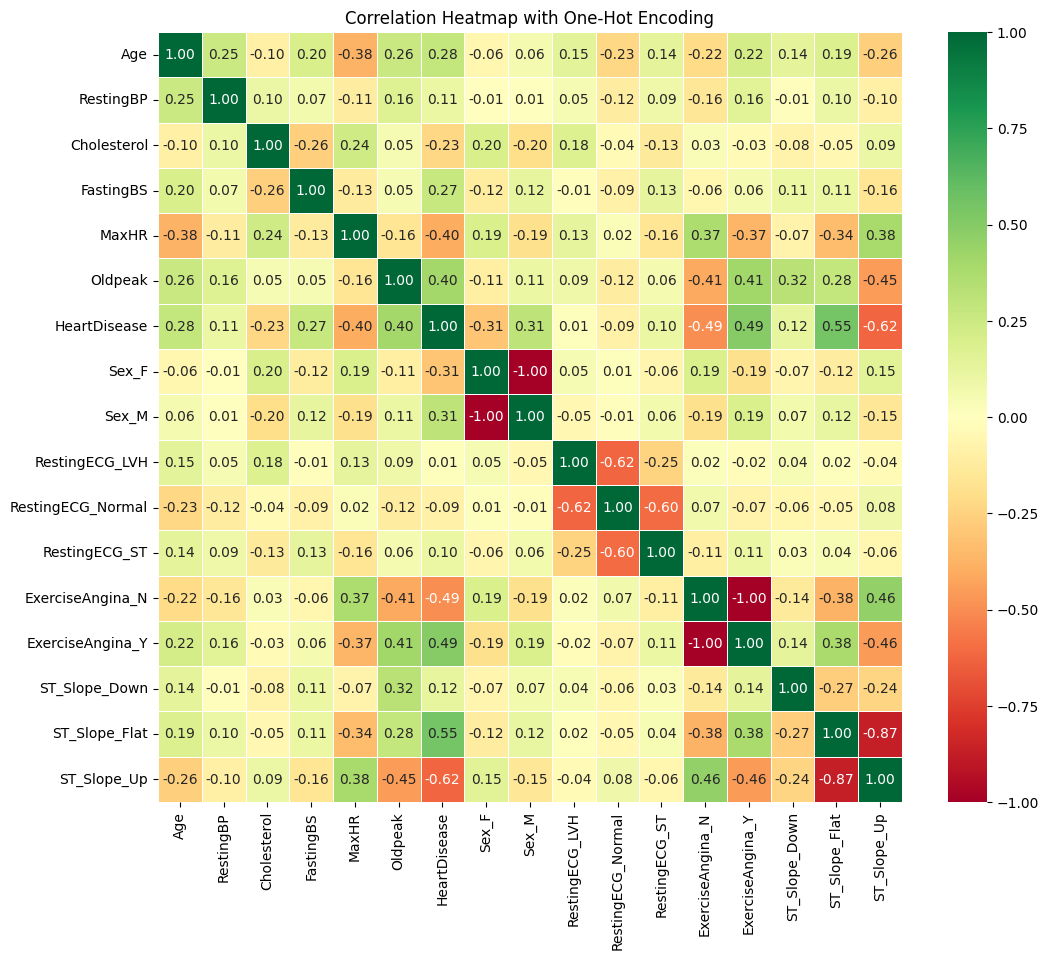

In [249]:
import seaborn as sns
df_encoded = pd.get_dummies(data)

# Generate correlation matrix
corr_matrix = df_encoded.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="RdYlGn" , fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap with One-Hot Encoding")
plt.show()

There is no extremely high correlation (close to 1 or -1) between features and Heart disease.

1.Moderate Positive Correlations: Age has a moderate positive correlation with HeartDisease (0.282). RestingBP, FastingBS, MaxHR, Oldpeak, Sex_M, RestingECG_LVH, RestingECG_ST, and ExerciseAngina_Y also have positive correlations with HeartDisease, but the correlations are not extremely high.

2.Moderate Negative Correlations: ST_Slope_Up has a moderate negative correlation with HeartDisease (-0.258). Sex_F and ST_Slope_Flat also have negative correlations with HeartDisease, but they are not extremely high. No Extremely High Correlations:

3.There is no pair of features with a correlation close to 1 or -1, indicating a very strong linear relationship.

It's important to note that correlation does not capture non-linear relationships, and other statistical techniques or machine learning models may reveal more complex patterns in the data.

Feature Selection or Dimensionality Reduction: If two features are highly correlated, you might consider whether both features are necessary. Redundant features might not contribute much additional information to the model.

In [250]:
model = Sequential()
model.add(Dense(12, input_dim=16, kernel_initializer='normal', activation='relu'))
model.add(Dense(4, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, activation='sigmoid'))
adam = Adam(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['binary_accuracy'])

In [251]:
print("Columns in training data:", X.columns)

Columns in training data: Index(['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG',
       'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope'],
      dtype='object')


In [252]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 12)                204       
                                                                 
 dense_55 (Dense)            (None, 4)                 52        
                                                                 
 dense_56 (Dense)            (None, 1)                 5         
                                                                 
Total params: 261 (1.02 KB)
Trainable params: 261 (1.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [253]:
model.fit(X_final, y_encoded, epochs=100, batch_size=10, verbose=1)


Epoch 1/100
74/74 [==============================] - 2s 4ms/step - loss: 0.6708 - binary_accuracy: 0.7248
Epoch 2/100
74/74 [==============================] - 0s 4ms/step - loss: 0.5649 - binary_accuracy: 0.7997
Epoch 3/100
74/74 [==============================] - 0s 5ms/step - loss: 0.4624 - binary_accuracy: 0.8351
Epoch 4/100
74/74 [==============================] - 0s 3ms/step - loss: 0.4104 - binary_accuracy: 0.8433
Epoch 5/100
74/74 [==============================] - 0s 2ms/step - loss: 0.3846 - binary_accuracy: 0.8474
Epoch 6/100
74/74 [==============================] - 0s 2ms/step - loss: 0.3710 - binary_accuracy: 0.8474
Epoch 7/100
74/74 [==============================] - 0s 3ms/step - loss: 0.3649 - binary_accuracy: 0.8556
Epoch 8/100
74/74 [==============================] - 0s 3ms/step - loss: 0.3625 - binary_accuracy: 0.8542
Epoch 9/100
74/74 [==============================] - 0s 2ms/step - loss: 0.3593 - binary_accuracy: 0.8515
Epoch 10/100
74/74 [==========================

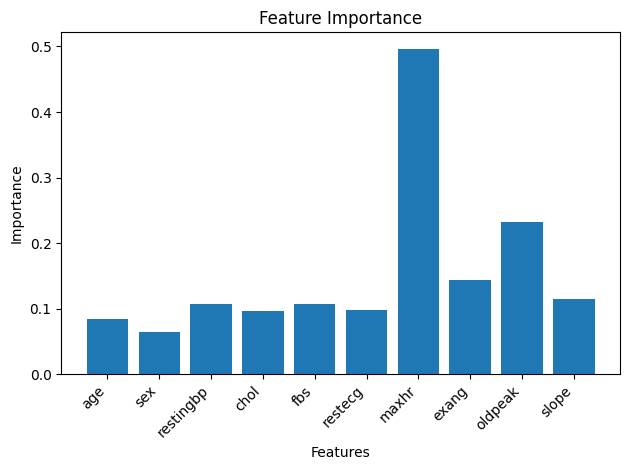

In [254]:

# Function to calculate gradients
def calculate_gradients(model, x, y):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(x_tensor)
        predictions = model(x_tensor)
        loss = tf.keras.losses.binary_crossentropy(y, predictions)

    gradients = tape.gradient(loss, x_tensor)
    return gradients.numpy()

# Convert y_encoded to a 2D array
y_encoded_2d = np.reshape(y_encoded, (-1, 1))

# Calculate gradients with respect to the normalized features
gradients_normalized = calculate_gradients(model, X_final, y_encoded_2d)

# Ensure that gradients and X have the same shape
if gradients_normalized.shape[1] != X_final.shape[1]:
    raise ValueError("Shapes of gradients and X do not match!")

# Calculate feature importance in the original scale
feature_importance_original = np.mean(np.abs(gradients_normalized) / np.std(X_final, axis=0), axis=0)

# Assuming you have already calculated feature_importance_original
# Make sure you replace this list with the correct column names of your original dataset
original_feature_names = ['age', 'sex', 'restingbp', 'chol', 'fbs', 'restecg', 'maxhr', 'exang', 'oldpeak', 'slope']

# Plotting feature importance
plt.bar(original_feature_names, feature_importance_original[:len(original_feature_names)])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


In [255]:
# Convert categorical features to categorical type
validation_data[categorical_features] = validation_data[categorical_features].astype('category')

# Separate features and labels for the validation set
X_val = validation_data.drop('HeartDisease', axis=1)
y_val = validation_data['HeartDisease']

# Convert categorical labels to numerical form
y_val_encoded = label_encoder.transform(y_val)

# Standardize numerical features for the validation set
X_val_scaled = scaler.transform(X_val.select_dtypes(include=np.number))

# One-hot encode categorical features for the validation set
X_val_categorical = pd.get_dummies(X_val[categorical_features])

# Concatenate scaled numerical features with one-hot encoded categorical features for the validation set
X_val_final = np.concatenate([X_val_scaled, X_val_categorical], axis=1)

# Evaluate the model on the validation set
loss, accuracy = model.evaluate(X_val_final, y_val_encoded)

# Print the accuracy
print(f'Accuracy on the validation set: {accuracy * 100:.2f}%')

6/6 [==============================] - 0s 3ms/step - loss: 0.2954 - binary_accuracy: 0.9022
Accuracy on the validation set: 90.22%


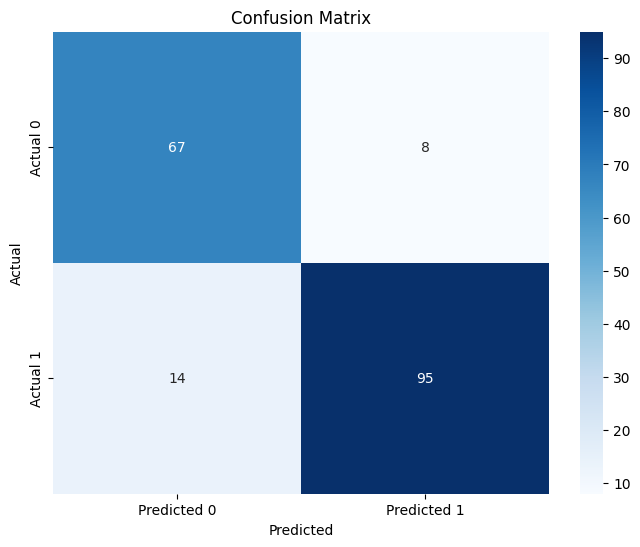

In [259]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_val_encoded and y_val_predictions are defined
conf_matrix = confusion_matrix(y_val_encoded, y_val_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


6/6 [==============================] - 0s 2ms/step

Classification Metrics:
Metric         Score          
------------------------------
Precision      0.9223
Recall         0.8716
F1 Score       0.8962
ROC AUC Score  0.9423


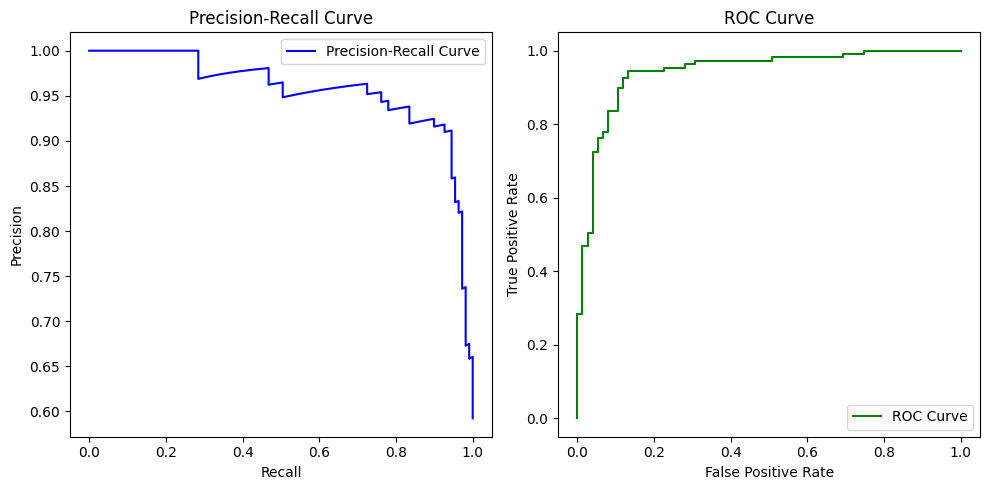

In [257]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities on the validation set
y_val_probabilities = model.predict(X_val_final)

# Convert probabilities to binary predictions
y_val_predictions = (y_val_probabilities > 0.66).astype(int)

# Calculate precision, recall, and F1 score
precision = precision_score(y_val_encoded, y_val_predictions)
recall = recall_score(y_val_encoded, y_val_predictions)
f1 = f1_score(y_val_encoded, y_val_predictions)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_val_encoded, y_val_probabilities)

# Print the metrics
print("\nClassification Metrics:")
print(f'{"Metric":<15}{"Score":<15}')
print('-' * 30)
print(f'{"Precision":<15}{precision:.4f}')
print(f'{"Recall":<15}{recall:.4f}')
print(f'{"F1 Score":<15}{f1:.4f}')
print(f'{"ROC AUC Score":<15}{roc_auc:.4f}')

# Calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_val_encoded, y_val_probabilities)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_val_encoded, y_val_probabilities)

# Plot Precision-Recall curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(recall, precision, label='Precision-Recall Curve', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

# Plot ROC curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label='ROC Curve', color='green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.tight_layout()
plt.show()



In [258]:
#manual testing
# Define the input record
#input_record = [57, 'M', 140, 293, 0, 'Lvh', 170, 'N', 1.2, 'Flat']
#input_record = [47, 'M', 130, 253, 0, 'Normal', 179, 'N', 0.0, 'Up']
#input_record = [48, 'M', 122, 222, 0, 'Lvh', 186, 'N', 0.0, 'Up']

#input_record = [55, 'F', 132, 342, 0, 'Normal', 166, 'N', 1.2, 'Up']
#input_record = [57, 'M', 124, 261, 0, 'Normal', 141, 'N', 0.3, 'Up']
input_record = [63, 'F', 150, 407, 0, 'Lvh', 154, 'N', 4.0, 'Flat']
# Create a DataFrame with the input record
columns = ['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']
input_df = pd.DataFrame([input_record], columns=columns)

# Convert categorical features to categorical type
input_df[categorical_features] = input_df[categorical_features].astype('category')

# Standardize numerical features
input_scaled = scaler.transform(input_df.select_dtypes(include=np.number))

# One-hot encode categorical features
input_categorical = pd.get_dummies(input_df[categorical_features])

# Ensure all one-hot encoded features are present in the input_final
for feature in X_categorical.columns:
    if feature not in input_categorical.columns:
        input_categorical[feature] = 0  # Add missing one-hot encoded feature with a default value

# Reorder the columns to match the order used during training
input_categorical = input_categorical[X_categorical.columns]

# Concatenate scaled numerical features with one-hot encoded categorical features
input_final = np.concatenate([input_scaled, input_categorical], axis=1)

# Make predictions
predictions = model.predict(input_final)

# Threshold the predictions (assuming 0.5 as the threshold)
binary_predictions = (predictions > 0.66).astype(int)

# Convert binary predictions back to original labels
decoded_predictions = label_encoder.inverse_transform(binary_predictions.ravel())
# Print the predictions
print("Predicted Heart Disease: {}".format(decoded_predictions[0]))

1/1 [==============================] - 0s 21ms/step
Predicted Heart Disease: 1
